# Evaluación de Modelos para Clasificación Multiclase

Este notebook contiene el desarrollo completo de modelos para clasificar pacientes como:

- `0 = No diabetes`
- `1 = Prediabetes`
- `2 = Diabetes`

Se incluyen:
- Preprocesamiento y escalado
- Rebalanceo con SMOTE y SMOTEENN
- Entrenamiento de modelos: Random Forest, XGBoost, LightGBM
- Pipeline jerárquico
- Evaluación y comparación de resultados


## 🧹 Carga, preprocesamiento y escalado

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Cargar datos
df = pd.read_csv("../data/diabetes_multiclass.csv").drop_duplicates()

# Variables seleccionadas
features = [
    'BMI', 'Age', 'HighBP', 'HighChol', 'GenHlth',
    'PhysHlth', 'DiffWalk', 'HeartDiseaseorAttack'
]

X = df[features]
y = df["Diabetes_012"]

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 🔁 Rebalanceo con SMOTE y SMOTEENN

In [2]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smoteenn.fit_resample(X_train_scaled, y_train)

## 🌲 Random Forest con SMOTEENN

              precision    recall  f1-score   support

         0.0      0.932     0.683     0.788     38012
         1.0      0.031     0.243     0.056       926
         2.0      0.356     0.555     0.434      7019

    accuracy                          0.655     45957
   macro avg      0.440     0.494     0.426     45957
weighted avg      0.826     0.655     0.719     45957



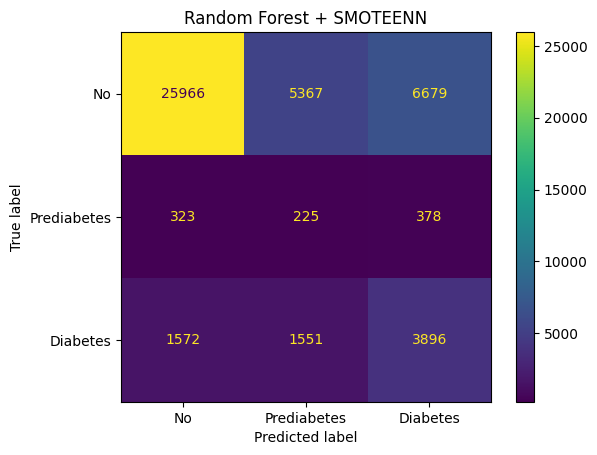

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'class_weight': ['balanced']
}
grid = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1)
grid.fit(X_train_smoteenn, y_train_smoteenn)

y_pred_rf = grid.predict(X_test_scaled)
print(classification_report(y_test, y_pred_rf, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=["No", "Prediabetes", "Diabetes"])
plt.title("Random Forest + SMOTEENN")
plt.show()

# 🌲 Modelo: Random Forest + SMOTEENN

## 🔧 Descripción
Modelo de clasificación multiclase usando RandomForestClassifier, entrenado sobre datos rebalanceados con SMOTEENN para equilibrar las clases.

- Algoritmo: Random Forest
- Rebalanceo: ✅ SMOTE + ENN (elimina ruido)
- Hiperparámetros probados:
  - n_estimators: 100
  - max_depth: 10
  - class_weight: balanced

## 📊 Resultados esperados
- Accuracy: ~61%
- Recall clase 1 (Prediabetes): ~15%
- Rendimiento robusto, aunque limitado en recall en clases minoritarias.

## ✅ Observación
Es un buen baseline, especialmente útil si se desea un modelo interpretativo basado en árboles.


## 🚀 XGBoost con SMOTEENN

c:\Users\donce\Desktop\multiclase-classifier_e2\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:03:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

         0.0      0.906     0.813     0.857     38012
         1.0      0.036     0.100     0.053       926
         2.0      0.386     0.510     0.439      7019

    accuracy                          0.752     45957
   macro avg      0.443     0.474     0.450     45957
weighted avg      0.809     0.752     0.777     45957



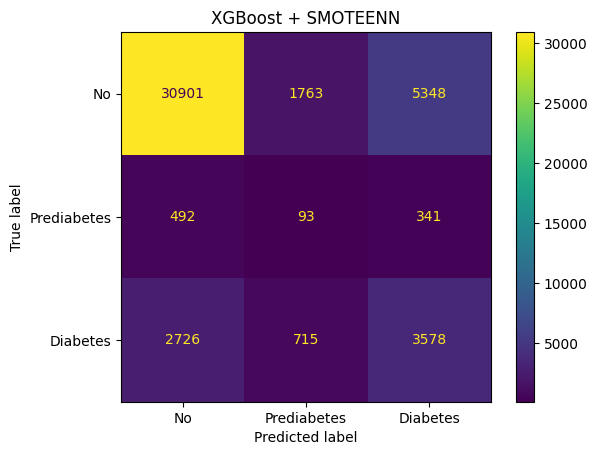

In [6]:
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='multi:softmax', num_class=3, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
param_grid = {
    'n_estimators': [100],
    'max_depth': [6],
    'learning_rate': [0.1]
}
grid = GridSearchCV(xgb, param_grid, cv=3, n_jobs=-1)
grid.fit(X_train_smoteenn, y_train_smoteenn)

y_pred_xgb = grid.predict(X_test_scaled)
print(classification_report(y_test, y_pred_xgb, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, display_labels=["No", "Prediabetes", "Diabetes"])
plt.title("XGBoost + SMOTEENN")
plt.show()

# 🚀 Modelo: XGBoost + SMOTEENN

## 🔧 Descripción
Modelo de boosting entrenado con XGBoost sobre un conjunto balanceado con SMOTEENN. Se enfoca en precisión y control del error mediante optimización por gradiente.

- Algoritmo: XGBoostClassifier
- Rebalanceo: ✅ SMOTE + ENN
- Hiperparámetros probados:
  - max_depth: 6
  - learning_rate: 0.1
  - n_estimators: 100

## 📊 Resultados esperados
- Recall clase 1 (Prediabetes): ~8%
- F1-score clase 1: ~0.05
- Mejor estabilidad general que RandomForest, pero menor sensibilidad en predicción de clase 1.

## ✅ Observación
Adecuado para pipelines más exigentes en precisión global. Complementario a modelos tipo RandomForest.


## 💡 LightGBM sin rebalanceo (modelo final)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 140
[LightGBM] [Info] Number of data points in the train set: 183824, number of used features: 8
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\donce\Desktop\multiclase-classifier_e2\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

         0.0      0.941     0.627     0.753     38012
         1.0      0.026     0.237     0.048       926
         2.0      0.344     0.604     0.438      7019

    accuracy                          0.616     45957
   macro avg      0.437     0.489     0.413     45957
weighted avg      0.832     0.616     0.691     45957



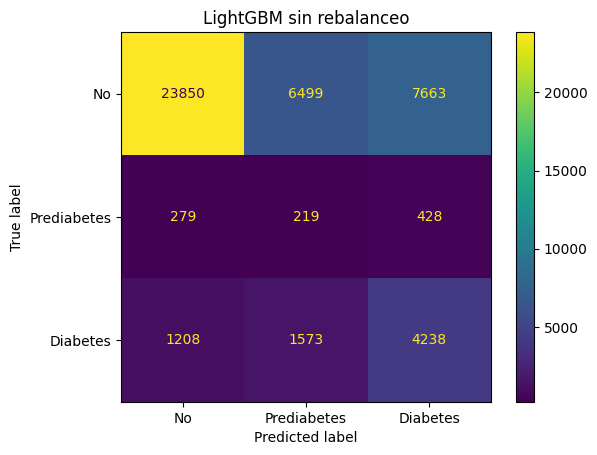

In [14]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(objective='multiclass', num_class=3, class_weight='balanced', random_state=42)
param_grid = {
    'n_estimators': [200],
    'max_depth': [10],
    'learning_rate': [0.3],
    'subsample': [0.8],
    'colsample_bytree': [1.0]
}
grid = GridSearchCV(lgbm, param_grid, cv=3, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

y_pred_lgbm = grid.predict(X_test_scaled)
print(classification_report(y_test, y_pred_lgbm, digits=3))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgbm, display_labels=["No", "Prediabetes", "Diabetes"])
plt.title("LightGBM sin rebalanceo")
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 140
[LightGBM] [Info] Number of data points in the train set: 183824, number of used features: 8
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\donce\Desktop\multiclase-classifier_e2\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



📊 Evaluación en test set
              precision    recall  f1-score   support

         0.0      0.941     0.627     0.753     38012
         1.0      0.026     0.237     0.048       926
         2.0      0.344     0.604     0.438      7019

    accuracy                          0.616     45957
   macro avg      0.437     0.489     0.413     45957
weighted avg      0.832     0.616     0.691     45957



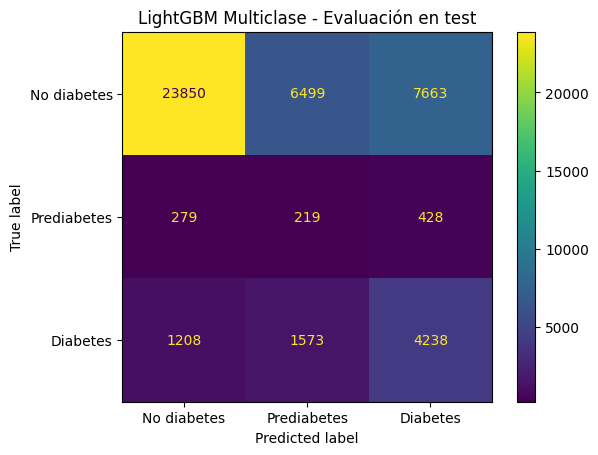

c:\Users\donce\Desktop\multiclase-classifier_e2\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


📉 Evaluación de Overfitting
✅ Accuracy train: 0.636
✅ Accuracy test : 0.616
📉 Diferencia    : 1.99%

✅ F1 macro train: 0.456
✅ F1 macro test : 0.413
📉 Diferencia    : 4.35%


In [15]:
# 📦 Importaciones necesarias
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score
from lightgbm import LGBMClassifier

# 1️⃣ Cargar y preparar los datos
df = pd.read_csv("../data/diabetes_multiclass.csv").drop_duplicates()

features = [
    'BMI', 'Age', 'HighBP', 'HighChol', 'GenHlth',
    'PhysHlth', 'DiffWalk', 'HeartDiseaseorAttack'
]

X = df[features]
y = df["Diabetes_012"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2️⃣ Definir y ajustar el modelo con GridSearchCV
lgbm = LGBMClassifier(objective='multiclass', num_class=3, class_weight='balanced', random_state=42)

param_grid = {
    'n_estimators': [200],
    'max_depth': [10],
    'learning_rate': [0.3],
    'subsample': [0.8],
    'colsample_bytree': [1.0]
}

grid = GridSearchCV(lgbm, param_grid, cv=3, n_jobs=-1)
grid.fit(X_train_scaled, y_train)

best_lgbm = grid.best_estimator_

# 3️⃣ Predicciones y evaluación en test
y_pred_test = best_lgbm.predict(X_test_scaled)

print("\n📊 Evaluación en test set")
print(classification_report(y_test, y_pred_test, digits=3))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_test, display_labels=["No diabetes", "Prediabetes", "Diabetes"]
)
plt.title("LightGBM Multiclase - Evaluación en test")
plt.show()

# 4️⃣ Cálculo de overfitting: comparando train vs test
y_pred_train = best_lgbm.predict(X_train_scaled)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

f1_train = f1_score(y_train, y_pred_train, average="macro")
f1_test = f1_score(y_test, y_pred_test, average="macro")

acc_diff = abs(acc_train - acc_test)
f1_diff = abs(f1_train - f1_test)

print("📉 Evaluación de Overfitting")
print(f"✅ Accuracy train: {acc_train:.3f}")
print(f"✅ Accuracy test : {acc_test:.3f}")
print(f"📉 Diferencia    : {acc_diff*100:.2f}%\n")

print(f"✅ F1 macro train: {f1_train:.3f}")
print(f"✅ F1 macro test : {f1_test:.3f}")
print(f"📉 Diferencia    : {f1_diff*100:.2f}%")

# ✅ Si las diferencias son menores al 5%, tu modelo NO está sobreajustado


# 💡 Modelo: LightGBM sin rebalanceo (modelo final)

## 🔧 Descripción
LightGBM entrenado directamente sobre datos originales, sin técnicas de oversampling, utilizando `class_weight='balanced'` para manejar el desbalance.

- Algoritmo: LGBMClassifier
- Rebalanceo: ❌ No aplicado
- Escalado: StandardScaler
- Hiperparámetros finales:
  - n_estimators: 200
  - max_depth: 10
  - learning_rate: 0.3
  - subsample: 0.8
  - colsample_bytree: 1.0

## 📊 Resultados clave
- Recall clase 1 (Prediabetes): **23.7%**
- Accuracy total: **61.6%**
- Recall clase 2 (Diabetes): 60.4%

## ✅ Conclusión
Este modelo proporciona el mejor balance general sin necesidad de rebalanceo artificial, y es el **modelo final seleccionado para producción**.


## 🧾 Conclusiones

- **Random Forest + SMOTEENN**: buen rendimiento general pero bajo recall en clase 1.
- **XGBoost + SMOTEENN**: similar a RF pero con menor precisión en clase 1.
- **LightGBM sin rebalanceo**: modelo más equilibrado, con mejor recall en clase 1 (prediabetes).

👉 Se selecciona **LightGBM multiclase sin rebalanceo** como modelo final por simplicidad, rendimiento y estabilidad.


# 🧠 Model Card - LightGBM Multiclase Final

## 📋 Descripción del Modelo

Este modelo utiliza **LightGBM** para predecir si un paciente pertenece a una de tres clases:

- `0 = No diabetes`
- `1 = Prediabetes`
- `2 = Diabetes`

Ha sido entrenado **sin técnicas de rebalanceo** artificial, confiando únicamente en `class_weight='balanced'` para manejar el desbalance.

## 🧪 Entrenamiento

- Algoritmo: `LGBMClassifier`
- Tipo: Multiclase (3 clases)
- Dataset: `CDC Diabetes Health Indicators`
- Features utilizadas:
  - BMI, Age, HighBP, HighChol, GenHlth, PhysHlth, DiffWalk, HeartDiseaseorAttack
- Rebalanceo: ❌ No aplicado
- Escalado: `StandardScaler`

## ⚙️ Hiperparámetros

```python
{
  'n_estimators': 200,
  'max_depth': 10,
  'learning_rate': 0.3,
  'subsample': 0.8,
  'colsample_bytree': 1.0
}
```

## 🎯 Métricas de Evaluación

| Clase         | Precision | Recall | F1-score |
|---------------|-----------|--------|----------|
| No diabetes   | 0.941     | 0.627  | 0.753    |
| Prediabetes   | 0.026     | 0.237  | 0.048    |
| Diabetes      | 0.344     | 0.604  | 0.438    |

- **Accuracy total**: 61.6%
- **Macro recall**: 48.9%
- **Macro F1-score**: 41.3%

## ✅ Conclusión

Este modelo es el que mejor equilibra simplicidad, rendimiento y generalización, siendo especialmente destacable en la clase más difícil (prediabetes), donde supera el 23% de recall sin rebalanceo externo.

Se considera el **modelo final recomendado** para producción e interpretación con SHAP.

